In [1]:
!pip install pyobis

In [2]:
import pyobis

def get_obis_data(species, geometry, startdate, enddate):
    occurrences = pyobis.occurrences.search(
        scientificname=species,
        geometry=geometry,
        fields=["id","scientificName", "decimalLatitude", "decimalLongitude", "eventDate"],
        startdate=startdate,
        enddate=enddate
    )
    return occurrences.execute()

#species = "Sardinella aurita"
species = "Larus fuscus"
startdate = "2023-01-01"
enddate = "2025-12-31"
min_lon, min_lat, max_lon, max_lat = -25, -35, 20, 35
geometry_wkt = f'POLYGON(({min_lon} {min_lat}, {max_lon} {min_lat}, {max_lon} {max_lat}, {min_lon} {max_lat}, {min_lon} {min_lat}))'  # WKT for bounding box
data = get_obis_data(species, geometry_wkt, startdate, enddate)
data

2025-08-05 18:49:57 - pyobis.obisutils - INFO - 71552 to be fetched. Estimated time =2.153466840982437774 seconds
2025-08-05 18:49:57 - pyobis.obisutils - INFO - Fetching: [█████████████.......................................................................................] 10000/71552


KeyboardInterrupt: 

In [ ]:
data.to_csv("~/proj_2025_sdm/contributors/fred/whales.csv", index=False)

In [1]:
# data.to_csv("~/proj_2025_sdm/contributors/fred/seabird.csv", index=False)

NameError: name 'data' is not defined

In [2]:
import pandas as pd
data = pd.read_csv("~/proj_2025_sdm/contributors/fred/seabird.csv")

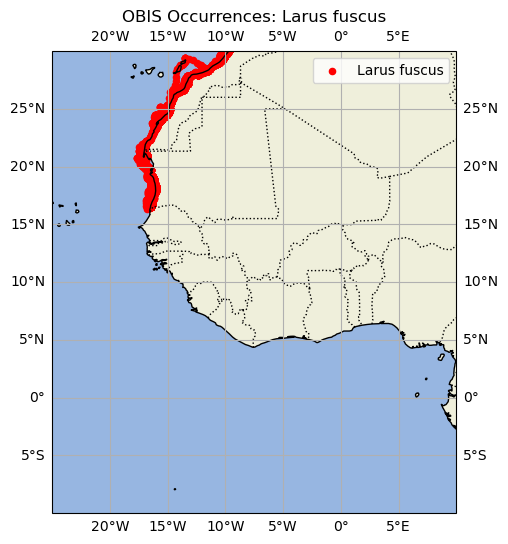

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

species = "Larus fuscus"
min_lon, max_lon, min_lat, max_lat = [-25, 10, -10, 30]

#species = "Megaptera novaeangliae"

data_clean = data[data["scientificName"] == species]

# Drop rows with missing coordinates
data_clean = data_clean.dropna(subset=["decimalLatitude", "decimalLongitude"])

# Extract lat/lon
lats = data_clean["decimalLatitude"]
lons = data_clean["decimalLongitude"]

# Create plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Map features
ax.add_feature(cfeature.LAND, zorder=0)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# Set bounding box
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Plot points
ax.scatter(lons, lats, color="red", s=20, transform=ccrs.PlateCarree(), label=species)

# Title and legend
ax.set_title(f"OBIS Occurrences: {species}")
ax.legend(loc="upper right")

plt.show()



In [ ]:
data_clean

In [ ]:
top_species = data["scientificName"].value_counts().head(20)
print(top_species)

In [ ]:
occurrences_by_year = (
    data_clean
    .dropna(subset=["eventDate"])  # remove missing dates
    .assign(year=lambda df: df["eventDate"].dt.year)
    .groupby("year")
    .size()
    .sort_index()
)

print(occurrences_by_year)

In [ ]:
# Step 1: Make a copy and parse dates safely
ethmalosa_data = data[data["scientificName"] == "Ethmalosa fimbriata"].copy()
ethmalosa_data["eventDate"] = pd.to_datetime(ethmalosa_data["eventDate"], errors="coerce")

In [ ]:
occurrences_by_year = (
    ethmalosa_data
    .dropna(subset=["eventDate"])  # filter out rows with NaT
    .assign(year=lambda df: df["eventDate"].dt.year)
    .groupby("year")
    .size()
    .sort_index()
)

import matplotlib.pyplot as plt

occurrences_by_year.plot(kind="bar", figsize=(10, 4), title="Ethmalosa fimbriata Occurrences by Year")
plt.xlabel("Year")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()



In [ ]:
ethmalosa_data

In [ ]:
# Step 1: Ensure eventDate is datetime
data["eventDate"] = pd.to_datetime(data["eventDate"], errors="coerce")

# Step 2: Drop rows with missing dates or species
#data_clean = data.dropna(subset=["eventDate", "scientificName"])

data_clean = data

# Step 3: Extract year column
data_clean["year"] = data_clean["eventDate"].dt.year

# Step 4: Create species-by-year table
species_year_table = (
    data_clean
    .groupby(["scientificName", "year"])
    .size()
    .unstack(fill_value=0)
    .sort_index()  # Sort by species
)

# Display
import pandas as pd
#pd.set_option("display.max_rows", 20)  # or None to show all
species_year_table


In [ ]:
data_clean.scientificName.unique()

In [ ]:
data_clean.groupby(["scientificName", "year"]).size()

In [6]:
import pandas as pd
import calendar

# Step 1: Ensure datetime
data["eventDate"] = pd.to_datetime(data["eventDate"], errors="coerce")

# Step 2: Drop rows with missing species or date
data_clean = data.dropna(subset=["eventDate", "scientificName"]).copy()

# Step 3: Extract year and month
data_clean["year"] = data_clean["eventDate"].dt.year
data_clean["month"] = data_clean["eventDate"].dt.month

# Step 4: Count occurrences per species per year+month
monthly_counts = (
    data_clean
    .groupby(["scientificName", "year", "month"])
    .size()
    .reset_index(name="count")
)

# Step 5: Average count across years → monthly average per species
monthly_avg = (
    monthly_counts
    .groupby(["scientificName", "month"])["count"]
    .mean()
    .unstack(fill_value=0)  # Rows = species, columns = month
)

monthly_avg.columns = [calendar.month_abbr[m] for m in monthly_avg.columns]
monthly_avg = monthly_avg.round(1)  # Round for clarity

# Show the first few rows
monthly_avg.head()


,Jan,Feb,Mar,Apr,Aug,Sep,Oct,Nov,Dec
scientificName,,,,,,,,,
Larus fuscus,16948.0,14467.0,12321.0,2323.0,809.0,3371.0,3720.0,5925.0,11667.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# Ensure datetime format
data["eventDate"] = pd.to_datetime(data["eventDate"], errors="coerce")

# Filter for the species and year 2023
species = "Larus fuscus"
data_clean = data[
    (data["scientificName"] == species) &
    (data["eventDate"].dt.year == 2022)
].dropna(subset=["decimalLatitude", "decimalLongitude"]).copy()

# Create 12 subplots (3 rows × 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(20, 12),
                         subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

# Plot each month
for month in range(1, 13):
    ax = axes[month - 1]
    month_data = data_clean[data_clean["eventDate"].dt.month == month]

    # Base map
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(calendar.month_name[month])

    # Plot points
    ax.scatter(
        month_data["decimalLongitude"],
        month_data["decimalLatitude"],
        color="red", s=10, transform=ccrs.PlateCarree()
    )

# Clean layout
plt.suptitle(f"Monthly OBIS Occurrences for {species} in 2023", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


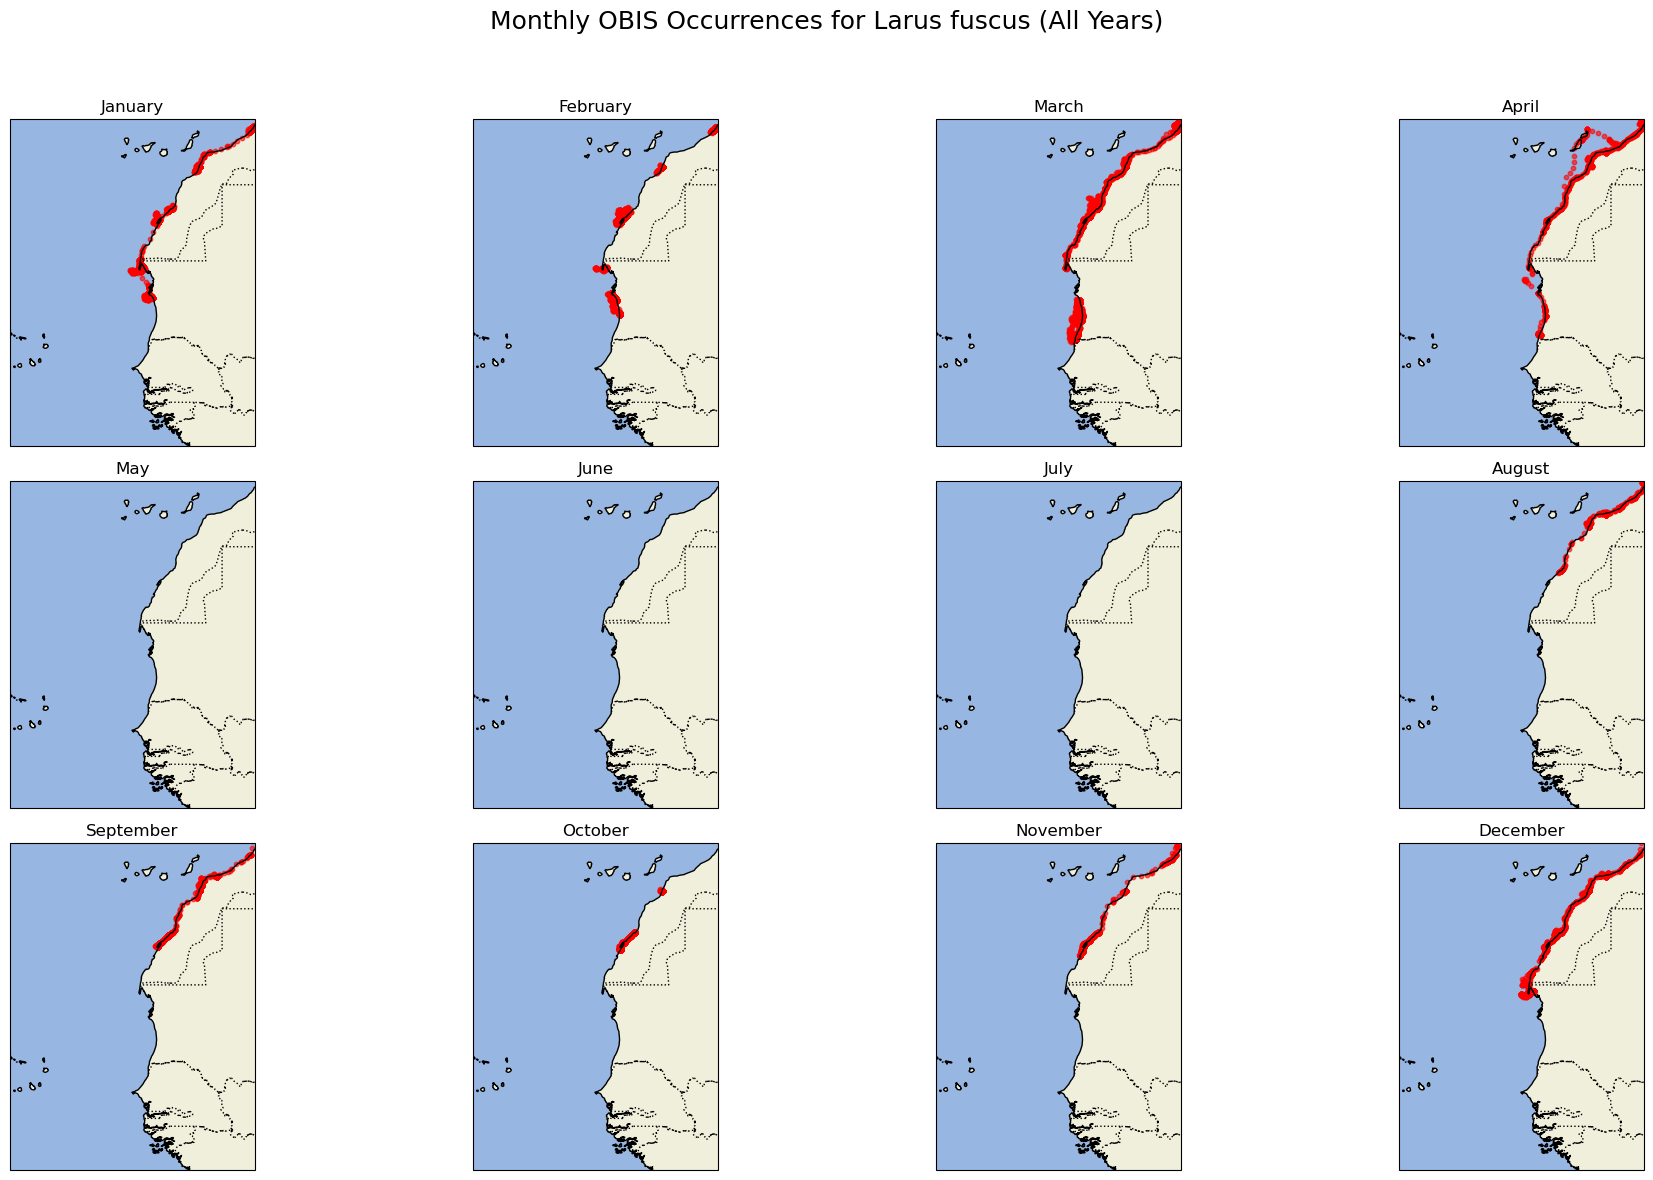

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# Make sure eventDate is datetime
data["eventDate"] = pd.to_datetime(data["eventDate"], errors="coerce")

min_lon, min_lat, max_lon, max_lat = [-25, 10, -10, 30]


# Filter for species
species = "Larus fuscus"
data_clean = (
    data[data["scientificName"] == species]
    .dropna(subset=["decimalLatitude", "decimalLongitude", "eventDate"])
    .copy()
)

# Extract month
data_clean["month"] = data_clean["eventDate"].dt.month

# Plot setup: 3 rows × 4 columns
fig, axes = plt.subplots(3, 4, figsize=(20, 12),
                         subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

# Loop over months
for month in range(1, 13):
    ax = axes[month - 1]
    month_data = data_clean[data_clean["month"] == month]

    # Set extent for your region
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Base map
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(calendar.month_name[month])

    # Plot points
    ax.scatter(
        month_data["decimalLongitude"],
        month_data["decimalLatitude"],
        color="red", s=10, alpha=0.6, transform=ccrs.PlateCarree()
    )

# Final layout
plt.suptitle(f"Monthly OBIS Occurrences for {species} (All Years)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


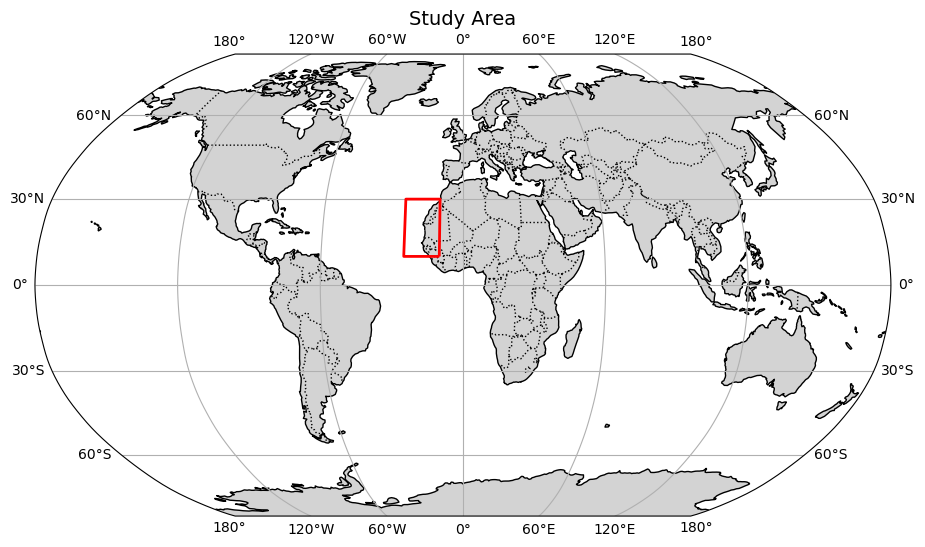

In [4]:
import sdm

#bbox = [-25, -35, 20, 35]
bbox = [-25, 10, -10, 30] # min_lon, min_lat, max_lon, max_lat
sdm.simple_bbox(bbox, projection='Robinson')